In [1]:
# MatMul

class MatMul:
    def __init__(self, W):
        self.params = [W]
        self.grads = [np.zeros_like(W)]
        self.x = None
        
    def forward(self, x):
        W, = self.params
        out = np.matmul(x, W)
        self.x = x
        
        return out
    
    def backward(self, dout):
        W, = self.params
        dx = np.matmul(dout, W.T)
        dW = np.matmul(self.x.T, dout)
        self.grads[0][...] = dW
        
        return dx

In [2]:
import numpy as np

c = np.array([[1, 0, 0, 0, 0 ,0 ,0]])
W = np.random.randn(7, 3)
layer = MatMul(W)
h = layer.forward(c)
print(h)

[[ 1.65128996 -1.37702749  0.59255328]]


In [3]:
### CBOW 모델의 추론 처리

c0 = np.array([1, 0, 0, 0, 0, 0, 0])
c1 = np.array([0, 0, 1, 0, 0, 0, 0])

#가중치 초기화
W_in = np.random.randn(7, 3)
W_out = np.random.randn(3, 7)

# 계층 생성
in_layer0 = MatMul(W_in)
in_layer1 = MatMul(W_in)
out_layer = MatMul(W_out)

h0 = in_layer0.forward(c0)
h1 = in_layer1.forward(c1)
h = 0.5 * (h0 + h1)
s = out_layer.forward(h)

print(s)

[ 0.35616357  0.7656925  -2.96344201 -0.70669687 -2.10596183 -0.19822163
  0.10029237]


In [4]:
### 말뭉치 텍스를 단어 ID로 변환

def preprocess(text):
    text = text.lower()
    text = text.replace('.', ' .')
    words = text.split(' ')

    word_to_id = {}
    id_to_word = {}
    
    for word in words:
        if word not in word_to_id:
            new_id = len(word_to_id)
            word_to_id[word] = new_id
            id_to_word[new_id] = word

    corpus = np.array([word_to_id[w] for w in words])

    return corpus, word_to_id, id_to_word

In [5]:
### 3.3.1 맥락과 타깃을 만드는 함수

def create_contexts_target(corpus, window_size=1):
    # target 계산
    target = corpus[window_size:-window_size]
    contexts = []
    
    # contexts 계산
    for idx in range(window_size, len(corpus)-window_size):
        cs=[]
        for t in range(-window_size, window_size + 1):
            if t == 0:
                continue
            cs.append(corpus[idx + t])
        contexts.append(cs)
        
    return np.array(contexts), np.array(target)

In [6]:
text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
print(corpus)
print(id_to_word)
contexts, target = create_contexts_target(corpus)

print(contexts)
print(target)

[0 1 2 3 4 1 5 6]
{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}
[[0 2]
 [1 3]
 [2 4]
 [3 1]
 [4 5]
 [1 6]]
[1 2 3 4 1 5]


In [7]:
def convert_one_hot(corpus, vocab_size):
    N = corpus.shape[0]

    if corpus.ndim == 1:
        one_hot = np.zeros((N, vocab_size), dtype=np.int32)
        for idx, word_id in enumerate(corpus):
            one_hot[idx, word_id] = 1

    elif corpus.ndim == 2:
        C = corpus.shape[1]
        one_hot = np.zeros((N, C, vocab_size), dtype=np.int32)
        for idx_0, word_ids in enumerate(corpus):
            for idx_1, word_id in enumerate(word_ids):
                one_hot[idx_0, idx_1, word_id] = 1

    return one_hot

In [8]:
### 3.3.2. 원핫 표현으로 변환

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

contexts, target = create_contexts_target(corpus, window_size=1)

vocab_size = len(word_to_id)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

In [9]:
print(contexts)
print(target)

[[[1 0 0 0 0 0 0]
  [0 0 1 0 0 0 0]]

 [[0 1 0 0 0 0 0]
  [0 0 0 1 0 0 0]]

 [[0 0 1 0 0 0 0]
  [0 0 0 0 1 0 0]]

 [[0 0 0 1 0 0 0]
  [0 1 0 0 0 0 0]]

 [[0 0 0 0 1 0 0]
  [0 0 0 0 0 1 0]]

 [[0 1 0 0 0 0 0]
  [0 0 0 0 0 0 1]]]
[[0 1 0 0 0 0 0]
 [0 0 1 0 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 0 0 1 0 0]
 [0 1 0 0 0 0 0]
 [0 0 0 0 0 1 0]]


In [10]:
def softmax(x):
    if x.ndim == 2:
        x = x - x.max(axis=1, keepdims=True)
        x = np.exp(x)
        x /= x.sum(axis=1, keepdims=True)
    elif x.ndim == 1:
        x = x - np.max(x)
        x = np.exp(x) / np.sum(np.exp(x))

    return x

In [11]:
def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    # Convert to correct label index if input data is one-hot-vector
    if t.size == y.size:
        t = t.argmax(axis=1)
             
    batch_size = y.shape[0]
    
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size

In [12]:
class SoftmaxWithLoss:
    def __init__(self):
        self.params, self.grads = [], []
        self.y = None
        self.t = None

    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)

        if self.t.size == self.y.size:
            self.t = self.t.argmax(axis=1)

        loss = cross_entropy_error(self.y, self.t)

        return loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]

        dx = self.y.copy()
        dx[np.arange(batch_size), self.t] -= 1
        dx *= dout
        dx = dx / batch_size

        return dx

In [13]:
def remove_duplicate(params, grads):
    params, grads = params[:], grads[:]

    while True:
        find_flg = False
        L = len(params)

        for i in range(0, L - 1):
            for j in range(i + 1, L):
                if params[i] is params[j]:
                    grads[i] += grads[j]
                    find_flg = True
                    params.pop(j)
                    grads.pop(j)
                elif params[i].ndim == 2 and params[j].ndim == 2 and \
                     params[i].T.shape == params[j].shape and np.all(params[i].T == params[j]):
                    grads[i] += grads[j].T
                    find_flg = True
                    params.pop(j)
                    grads.pop(j)

                if find_flg: break
            if find_flg: break

        if not find_flg: break

    return params, grads

In [14]:
import time

class Trainer:
    def __init__(self, model, optimizer):
        self.model = model
        self.optimizer = optimizer
        self.loss_list = []
        self.eval_interval = None
        self.current_epoch = 0

    def fit(self, x, t, max_epoch=10, batch_size=32, max_grad=None, eval_interval=20):
        data_size = len(x)
        max_iters = data_size // batch_size
        self.eval_interval = eval_interval
        model, optimizer = self.model, self.optimizer
        total_loss = 0
        loss_count = 0

        start_time = time.time()
        for epoch in range(max_epoch):
            idx = np.random.permutation(np.arange(data_size))
            x = x[idx]
            t = t[idx]

            for iters in range(max_iters):
                batch_x = x[iters*batch_size:(iters+1)*batch_size]
                batch_t = t[iters*batch_size:(iters+1)*batch_size]

                # Finding gradients and updating parameters
                loss = model.forward(batch_x, batch_t)
                model.backward()
                params, grads = remove_duplicate(model.params, model.grads)
                
                if max_grad is not None:
                    clip_grads(grads, max_grad)
                optimizer.update(params, grads)
                total_loss += loss
                loss_count += 1

                if (eval_interval is not None) and (iters % eval_interval) == 0:
                    avg_loss = total_loss / loss_count
                    elapsed_time = time.time() - start_time
                    print('| epoch %d |  iter %d / %d | time %d[s] | loss %.2f'
                          % (self.current_epoch + 1, iters + 1, max_iters, elapsed_time, avg_loss))
                    self.loss_list.append(float(avg_loss))
                    total_loss, loss_count = 0, 0

            self.current_epoch += 1

    def plot(self, ylim=None):
        x = np.arange(len(self.loss_list))
        if ylim is not None:
            plt.ylim(*ylim)
        plt.plot(x, self.loss_list, label='train')
        plt.xlabel('iterations (x' + str(self.eval_interval) + ')')
        plt.ylabel('loss')
        plt.show()

In [15]:
### 3.4.1 학습 코드 구현

class Adam:
    '''
    Adam (http://arxiv.org/abs/1412.6980v8)
    '''
    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None
        
    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = [], []
            for param in params:
                self.m.append(np.zeros_like(param))
                self.v.append(np.zeros_like(param))
        
        self.iter += 1
        lr_t = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)

        for i in range(len(params)):
            self.m[i] += (1 - self.beta1) * (grads[i] - self.m[i])
            self.v[i] += (1 - self.beta2) * (grads[i]**2 - self.v[i])
            
            params[i] -= lr_t * self.m[i] / (np.sqrt(self.v[i]) + 1e-7)

In [16]:
### 3.4 CBOW 모델 구현
class SimpleCBOW:
    def __init__(self, vocab_size, hidden_size):
        V, H = vocab_size, hidden_size

        # weight initialization
        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(H, V).astype('f')

        # the preparation of a layer
        self.in_layer0 = MatMul(W_in)
        self.in_layer1 = MatMul(W_in)
        self.out_layer = MatMul(W_out)
        self.loss_layer = SoftmaxWithLoss()

        # List all weights and gradients
        layers = [self.in_layer0, self.in_layer1, self.out_layer]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads

        # Set word distribution expression in member variables
        self.word_vecs = W_in

    def forward(self, contexts, target):
        h0 = self.in_layer0.forward(contexts[:, 0])
        h1 = self.in_layer1.forward(contexts[:, 1])
        h = (h0 + h1) * 0.5
        score = self.out_layer.forward(h)
        loss = self.loss_layer.forward(score, target)
        return loss

    def backward(self, dout=1):
        ds = self.loss_layer.backward(dout)
        da = self.out_layer.backward(ds)
        da *= 0.5
        self.in_layer1.backward(da)
        self.in_layer0.backward(da)
        return None

| epoch 1 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 2 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 3 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 4 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 5 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 6 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 7 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 8 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 9 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 10 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 11 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 12 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 13 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 14 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 15 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 16 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 17 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 18 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 19 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 20 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 21 |  iter 1 / 2 | ti

| epoch 281 |  iter 1 / 2 | time 0[s] | loss 1.03
| epoch 282 |  iter 1 / 2 | time 0[s] | loss 0.83
| epoch 283 |  iter 1 / 2 | time 0[s] | loss 1.03
| epoch 284 |  iter 1 / 2 | time 0[s] | loss 0.84
| epoch 285 |  iter 1 / 2 | time 0[s] | loss 1.10
| epoch 286 |  iter 1 / 2 | time 0[s] | loss 0.92
| epoch 287 |  iter 1 / 2 | time 0[s] | loss 0.89
| epoch 288 |  iter 1 / 2 | time 0[s] | loss 1.08
| epoch 289 |  iter 1 / 2 | time 0[s] | loss 0.76
| epoch 290 |  iter 1 / 2 | time 0[s] | loss 0.95
| epoch 291 |  iter 1 / 2 | time 0[s] | loss 1.01
| epoch 292 |  iter 1 / 2 | time 0[s] | loss 1.05
| epoch 293 |  iter 1 / 2 | time 0[s] | loss 0.81
| epoch 294 |  iter 1 / 2 | time 0[s] | loss 1.05
| epoch 295 |  iter 1 / 2 | time 0[s] | loss 0.79
| epoch 296 |  iter 1 / 2 | time 0[s] | loss 0.94
| epoch 297 |  iter 1 / 2 | time 0[s] | loss 0.85
| epoch 298 |  iter 1 / 2 | time 0[s] | loss 1.05
| epoch 299 |  iter 1 / 2 | time 0[s] | loss 0.85
| epoch 300 |  iter 1 / 2 | time 0[s] | loss 1.06


| epoch 544 |  iter 1 / 2 | time 0[s] | loss 0.59
| epoch 545 |  iter 1 / 2 | time 0[s] | loss 0.58
| epoch 546 |  iter 1 / 2 | time 0[s] | loss 0.78
| epoch 547 |  iter 1 / 2 | time 0[s] | loss 0.48
| epoch 548 |  iter 1 / 2 | time 0[s] | loss 0.75
| epoch 549 |  iter 1 / 2 | time 0[s] | loss 0.50
| epoch 550 |  iter 1 / 2 | time 0[s] | loss 0.63
| epoch 551 |  iter 1 / 2 | time 0[s] | loss 0.75
| epoch 552 |  iter 1 / 2 | time 0[s] | loss 0.53
| epoch 553 |  iter 1 / 2 | time 0[s] | loss 0.60
| epoch 554 |  iter 1 / 2 | time 0[s] | loss 0.62
| epoch 555 |  iter 1 / 2 | time 0[s] | loss 0.70
| epoch 556 |  iter 1 / 2 | time 0[s] | loss 0.61
| epoch 557 |  iter 1 / 2 | time 0[s] | loss 0.58
| epoch 558 |  iter 1 / 2 | time 0[s] | loss 0.62
| epoch 559 |  iter 1 / 2 | time 0[s] | loss 0.81
| epoch 560 |  iter 1 / 2 | time 0[s] | loss 0.40
| epoch 561 |  iter 1 / 2 | time 0[s] | loss 0.62
| epoch 562 |  iter 1 / 2 | time 0[s] | loss 0.69
| epoch 563 |  iter 1 / 2 | time 0[s] | loss 0.55


| epoch 829 |  iter 1 / 2 | time 1[s] | loss 0.52
| epoch 830 |  iter 1 / 2 | time 1[s] | loss 0.44
| epoch 831 |  iter 1 / 2 | time 1[s] | loss 0.44
| epoch 832 |  iter 1 / 2 | time 1[s] | loss 0.46
| epoch 833 |  iter 1 / 2 | time 1[s] | loss 0.51
| epoch 834 |  iter 1 / 2 | time 1[s] | loss 0.56
| epoch 835 |  iter 1 / 2 | time 1[s] | loss 0.49
| epoch 836 |  iter 1 / 2 | time 1[s] | loss 0.48
| epoch 837 |  iter 1 / 2 | time 1[s] | loss 0.49
| epoch 838 |  iter 1 / 2 | time 1[s] | loss 0.48
| epoch 839 |  iter 1 / 2 | time 1[s] | loss 0.49
| epoch 840 |  iter 1 / 2 | time 1[s] | loss 0.45
| epoch 841 |  iter 1 / 2 | time 1[s] | loss 0.44
| epoch 842 |  iter 1 / 2 | time 1[s] | loss 0.56
| epoch 843 |  iter 1 / 2 | time 1[s] | loss 0.36
| epoch 844 |  iter 1 / 2 | time 1[s] | loss 0.48
| epoch 845 |  iter 1 / 2 | time 1[s] | loss 0.67
| epoch 846 |  iter 1 / 2 | time 1[s] | loss 0.40
| epoch 847 |  iter 1 / 2 | time 1[s] | loss 0.48
| epoch 848 |  iter 1 / 2 | time 1[s] | loss 0.44


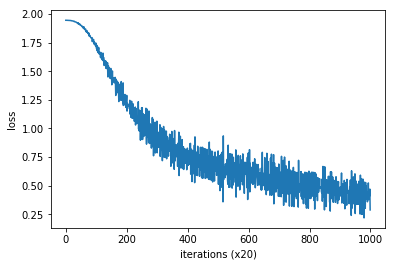

you [-1.0189422  -0.91166073  1.6480061  -0.71211404 -0.8358288 ]
say [-0.01946388  1.1766013   0.35874593  1.1610314   1.1758682 ]
goodbye [-1.0458578  -0.9180885  -0.08102933 -1.1267978  -1.0944645 ]
and [1.5580194  0.96159405 1.5290062  0.95012426 0.9422874 ]
i [-1.0138284  -0.90713125 -0.06940629 -1.1075021  -1.0471977 ]
hello [-1.0080683 -0.9011932  1.6552026 -0.7422806 -0.8005005]
. [-1.4922124  1.0471749 -1.362185   1.057018   1.0624955]


In [19]:
import matplotlib.pyplot as plt

window_size = 1
hidden_size = 5
batch_size = 3
max_epoch = 1000

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

vocab_size = len(word_to_id)
contexts, target = create_contexts_target(corpus, window_size)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

model = SimpleCBOW(vocab_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

trainer.fit(contexts, target, max_epoch, batch_size)
trainer.plot()
plt.show()

word_vecs = model.word_vecs
for word_id, word in id_to_word.items():
    print(word, word_vecs[word_id])